In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(vegan)
library(plyr); library(dplyr)
library(RColorBrewer)
library(stats)
library(reshape2)

/home/chantal/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  warnings.warn(x, RRuntimeWarning)
/home/chantal/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: iterators

  warnings.warn(x, RRuntimeWarning)
/home/chantal/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/home/chantal/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: permute

  warnings.warn(x, RRuntimeWarning)
/home/chantal/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: lattice

  warnings.warn(x, RRuntimeWarning

## Running Pairwise Comparisons on Filtered fasta file

In [ ]:
! head data/SIP_Bulk_otusn.pick.fasta

In [ ]:
#! grep -c ">" data/otusn.pick.fasta
! grep -c ">" data/SIP_Bulk_otusn.pick.fasta

In [ ]:
%%bash
ionice -c2 -n3 \
mothur "#pairwise.seqs(fasta=data/SIP_Bulk_otusn.pick.fasta, calc=onegap, countends=false, \
processors=10, output=square)" #> /dev/null

#mothur "#pairwise.seqs(fasta=data/otusn.pick.fasta, calc=onegap, countends=false, \
#processors=10, output=square)" #> /dev/null

In [ ]:
!tail data/SIP_Bulk_otusn.pick.square.dist | cut -c1-80

In [ ]:
! grep -c "OTU" data/SIP_Bulk_otusn.pick.square.dist

## Running t-SNE analysis on pairwise distance matrix

In [ ]:
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from math import log

In [ ]:
%matplotlib inline

In [ ]:
dist_lines = open("data/SIP_Bulk_otusn.pick.square.dist").readlines()
def line2array(line):
    line = line.rstrip()
    return np.array(map(float, line.split("\t")[1:]))
distmat = np.vstack([line2array(line) for line in dist_lines[1:]])

In [ ]:
def getOTU(line):
    line = line.rstrip()
    return np.array(line.split("\t")[0:1])
OTU= np.vstack(getOTU(line) for line in dist_lines[1:])

In [ ]:
print OTU

In [ ]:
print distmat

In [ ]:
def corr(a):
    if (a >= 0.75): return a
    else: return (-3/4*(log(1-(4/3*a))))

In [ ]:
vecfunc = np.vectorize(corr)
result=vecfunc(distmat)

In [ ]:
print result

In [ ]:
model = TSNE(n_components=2, random_state=0)
tsne_coords = model.fit_transform(result) 

In [ ]:
tsne_coords

In [ ]:
combo = np.concatenate((tsne_coords, OTU), axis = 1)

In [ ]:
combo

## Visualizing t-SNE coordinates

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(frameon=False)
plt.setp(ax, xticks=(), yticks=())
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,
                wspace=0.0, hspace=0.0)
plt.scatter(combo[:, 0], combo[:, 1])

## Importing python variables of t-SNE coordinates into R

In [ ]:
%Rpush combo

In [ ]:
%%R
colnames(combo) = c("tsne_1", "tsne_2", "OTU")

In [ ]:
%%R
combo = as.data.frame(combo)

In [ ]:
%%R
head(combo)

In [ ]:
%%R
combo$OTU = gsub(" ", "", combo$OTU, fixed = TRUE)

In [ ]:
%%R
head(combo)

## Creating csv with t-SNE information

In [ ]:
%%R
write.table(combo, "data/tSNE.csv", row.names = FALSE, sep = ",")

# Start notebook here if just visualizing t-SNE

In [4]:
%%R
combo = read.csv("data/tSNE.csv")

## Adding Metadata to t-SNE coordinates

In [5]:
%%R
sample.md = read.table("data/Metadata_fungi.txt", 
                comment.char = "",
                header = TRUE,
                colClasses = c("Density" = "numeric"))
rownames(sample.md) = as.character(sample.md[, 1])

sample.md = sample_data(sample.md)

In [6]:
%%R
physeq = import_biom("data/SIP_Bulk_otu_table_wtax.biom")
print(physeq)
sample.data = import_qiime_sample_data("data/Metadata_fungi.txt")
physeq = merge_phyloseq(physeq,sample.data)
print(physeq)
physeq.md = sample_data(physeq)
physeq.fungi = prune_samples((physeq.md$Treatment %in% c("12CCPS","13CCPS"))& 
                             (physeq.md$SampleID != c("D312.6")),  physeq)
physeq.fungi.prune = prune_samples(sample_sums(physeq.fungi) > 5360, physeq.fungi)
print (physeq.fungi.prune)
physeq.fungi.snorm = transform_sample_counts(physeq.fungi.prune, function(x) x/sum(x))
#physeq.fungi.thresh = filter_taxa(physeq.fungi.snorm, function(x) sum(x > 0) / length(x) > (0.25), TRUE)
#physeq.fungi.thresh.min = filter_taxa(physeq.fungi.thresh, function(x) sum(x) > 5000, TRUE)
#physeq.fungi.thresh = filter_taxa(physeq.SIP.snorm, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)
#print(physeq.fungi.thresh)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1905 taxa and 181 samples ]
tax_table()   Taxonomy Table:    [ 1905 taxa by 7 taxonomic ranks ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1905 taxa and 181 samples ]
sample_data() Sample Data:       [ 181 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 1905 taxa by 7 taxonomic ranks ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1905 taxa and 170 samples ]
sample_data() Sample Data:       [ 170 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 1905 taxa by 7 taxonomic ranks ]


In [7]:
%%R
mdf= tbl_df(psmelt(physeq.fungi.snorm))

In [8]:
%%R
d = left_join(mdf, combo)

/home/chantal/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Joining, by = "OTU"

  warnings.warn(x, RRuntimeWarning)


In [9]:
%%R
length(unique(d$OTU))

[1] 1905


In [10]:
%%R
d$Rank2 = gsub("p__", "", d$Rank2)
d$Rank3 = gsub("c__", "", d$Rank3)
d$Rank4 = gsub("o__", "", d$Rank4)

In [11]:
%%R
d_sub = select(d, OTU, Sample, Day, tsne_1, tsne_2, Density, Rank1, Rank2, Rank3, Treatment)

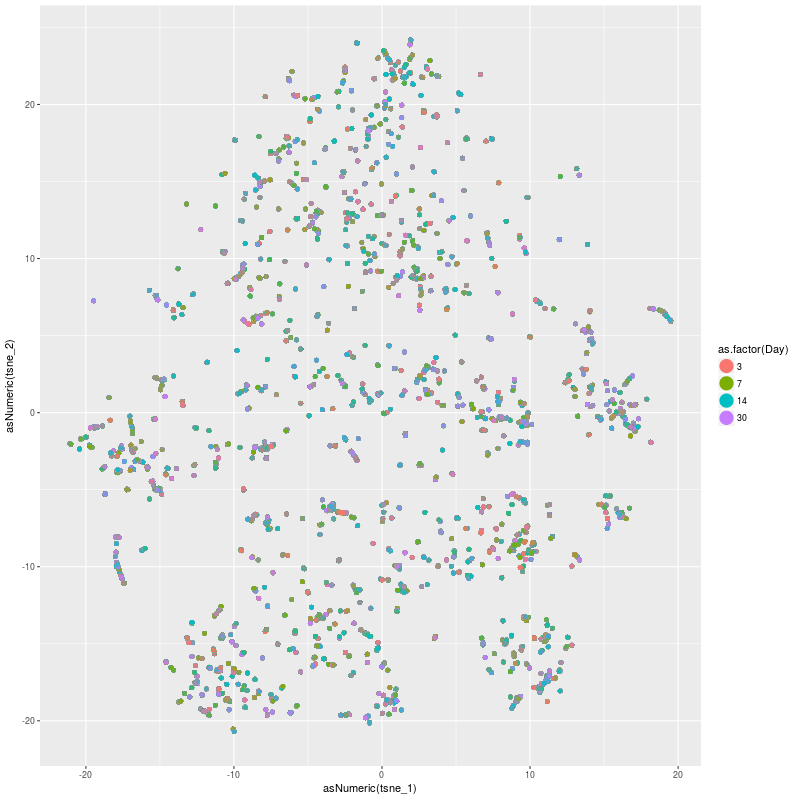

In [12]:
%%R -w 800 -h 800

asNumeric = function(x) { as.numeric(as.character(x)) }
p = ggplot(d_sub, aes(x = asNumeric(tsne_1), y = asNumeric(tsne_2)))+
    geom_point(aes(fill = as.factor(Day), color = as.factor(Day), alpha = 0.85), pch = 21) +
    guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))


p      

In [13]:
%%R
l2fc = read.csv("data/l2fc_UNITE_MW.csv", header = TRUE, sep = ",")

In [14]:
%%R
length(unique(l2fc$OTU))

[1] 560


In [15]:
%%R
d2 = left_join(combo, l2fc)

In [16]:
%%R
test = filter(l2fc, !(OTU %in% combo$OTU))
length(unique(test$OTU))

[1] 0


In [17]:
%%R
filter(combo, OTU == 'OTU.30467')

     tsne_1    tsne_2       OTU
1 0.8744059 -18.70911 OTU.30467


In [18]:
%%R
test$OTU

factor(0)
560 Levels: OTU.1 OTU.10 OTU.1000 OTU.1002 OTU.1003 OTU.1004 ... OTU.9995


In [19]:
%%R
length(unique(combo$OTU))

[1] 1905


In [20]:
%%R
head(d2)
d2$logp = -log10(d2$padj)

In [21]:
%%R
d2$Resp_status[d2$padj > 0.10] = "Non-responder"
d2$Resp_status[d2$padj <= 0.10] = "Responder"
d2$Resp_status[is.na(d2$padj)] = "Non-responder"

In [22]:
%%R
filter(l2fc, padj <= 0.10) %>%   summarize(n_incorp_OTUs = OTU %>% unique %>% length) 


  n_incorp_OTUs
1           193


In [23]:
%%R
filter(d2, padj <= 0.10) %>%   summarize(n_incorp_OTUs = OTU %>% unique %>% length) 


  n_incorp_OTUs
1           193


In [24]:
%%R
d2 %>%   summarize(n_incorp_OTUs = OTU %>% unique %>% length) 

  n_incorp_OTUs
1          1905


In [25]:
%%R
length((l2fc$OTU))

[1] 1521


## Visualizing t-SNE Coordinates with Metadata painted on

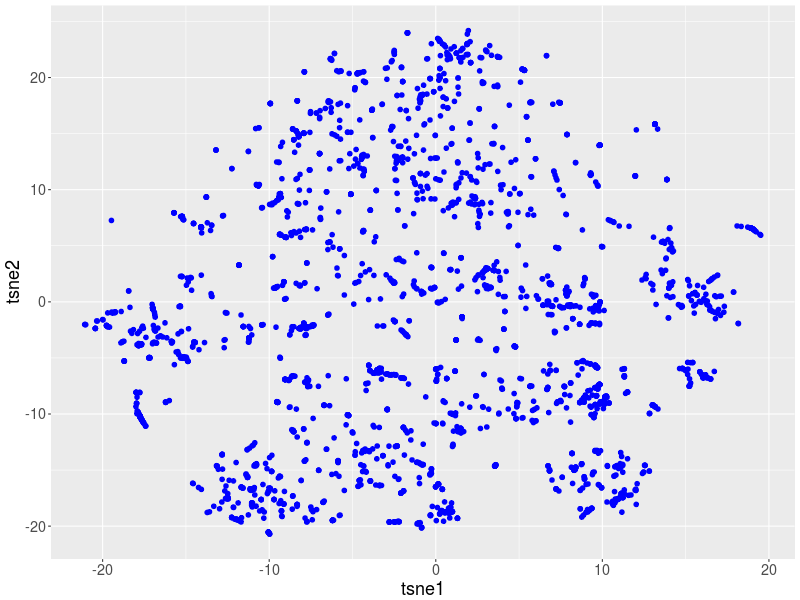

In [26]:
%%R -w 800 -h 600

my_palette <- colorRampPalette(c("red", "yellow", "green"))(n = 299)


asNumeric = function(x) { as.numeric(as.character(x)) }
p = ggplot(d2, aes(x = asNumeric(tsne_1), y = asNumeric(tsne_2)))+
    geom_point(fill = "blue", color = "blue", size = 2, pch = 21) +
    guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))  + 
    #scale_colour_gradient(limits = c(0, 1), low="red", high="blue", name = "Adjusted p-value") +
    guides(color=FALSE) + theme(text = element_text(size=18)) 


p = p + xlab("tsne1") + ylab("tsne2")


p   

In [27]:
%%R
ggsave("data/figs/tnseFig_nolabels.png", p, height = 7, width = 7)

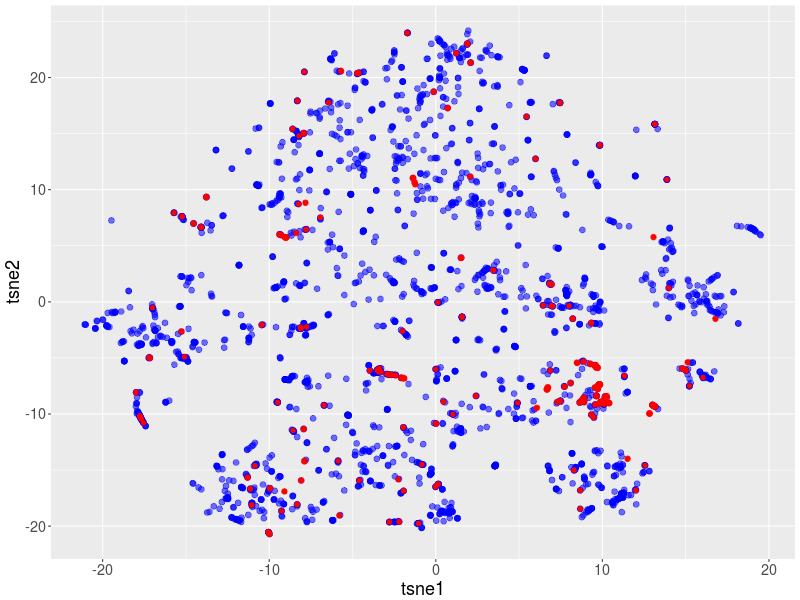

In [28]:
%%R -w 800 -h 600

my_palette <- c("blue", "red", "grey")


asNumeric = function(x) { as.numeric(as.character(x)) }
p = ggplot(d2, aes(x = asNumeric(tsne_1), y = asNumeric(tsne_2)))+
    geom_point(aes(fill = Resp_status, color = Resp_status, alpha = 0.85), size = 2.5, pch = 21) +
    guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=5))) +
    scale_shape_discrete(name = "Responder Status") + 
    scale_colour_manual(values = my_palette) +
    scale_fill_manual(values = my_palette, name = "Responder Status")+
    guides(color=FALSE) + theme(text = element_text(size=18)) 

p = p + geom_point(data = subset(d2, padj <= 0.10), shape = 20, size = 3, color = "red")

p = p + theme(legend.position ="bottom")

p = p + xlab("tsne1") + ylab("tsne2")

p = p + guides(fill = FALSE)


p     

In [29]:
%%R
ggsave("data/figs/tnseFig_resp.png", p, height = 8, width = 8)

In [30]:
%%R
na = filter(d2, is.na(Rank3))
rest = filter(d2, !is.na(Rank3))
na$group = "Unclassified"
rest$group = rest$Rank3
g = rbind(na, rest)

In [31]:
%%R
head(g)

     tsne_1    tsne_2    OTU Day log2FoldChange            p         padj
1  9.636409 -8.392377  OTU.7   7      1.3005906 3.150087e-04 4.745674e-03
2  9.636409 -8.392377  OTU.7  14      4.8415520 7.204844e-23 6.052069e-21
3  9.636409 -8.392377  OTU.7  30      0.7496056 2.279720e-01 8.613261e-01
4  9.636409 -8.392377  OTU.7   3      3.4498532 9.388700e-37 7.041525e-34
5 -2.560815  1.808797 OTU.17   7      0.4423803 2.071487e-01 8.112315e-01
6 -2.560815  1.808797 OTU.17  14     -0.1616244 7.949879e-01 1.000000e+00
     Rank1         Rank2 Rank3 Rank4 Rank5 Rank6 Rank7 density_min density_max
1 k__Fungi p__Ascomycota  <NA>  <NA>  <NA>  <NA>  <NA>        1.72        1.75
2 k__Fungi p__Ascomycota  <NA>  <NA>  <NA>  <NA>  <NA>        1.74        1.77
3 k__Fungi p__Ascomycota  <NA>  <NA>  <NA>  <NA>  <NA>        1.70        1.73
4 k__Fungi p__Ascomycota  <NA>  <NA>  <NA>  <NA>  <NA>        1.72        1.75
5 k__Fungi p__Ascomycota  <NA>  <NA>  <NA>  <NA>  <NA>        1.70        1.73
6 k__Fun

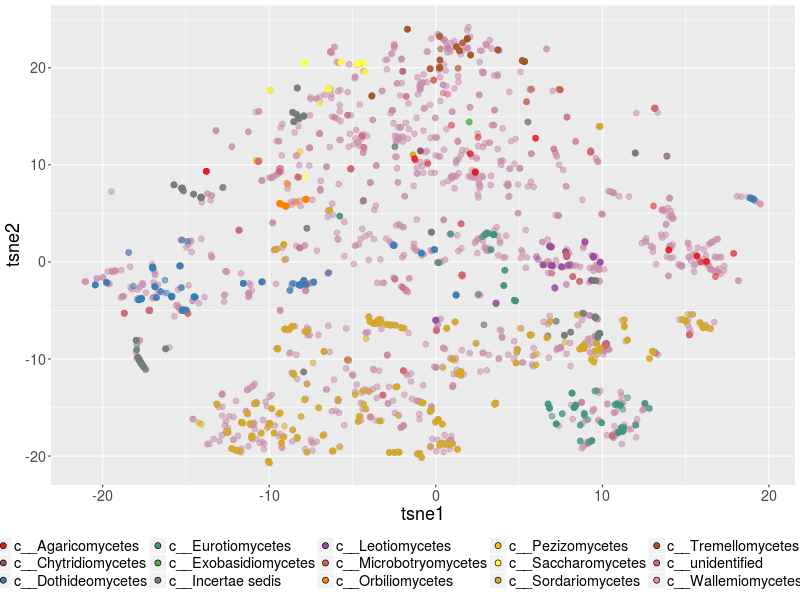

In [32]:
%%R -w 800 -h 600

#my_palette <- colorRampPalette(c("red", "yellow", "green"))(n = 299)


asNumeric = function(x) { as.numeric(as.character(x)) }
p2 = ggplot(g, aes(x = asNumeric(tsne_1), y = asNumeric(tsne_2)))
#p = p + geom_point(data = subset(d2, padj <= 0.10), shape = 20, size = 6)
p2 = p2 + geom_point(aes(fill = group, color = group, alpha = 0.85), pch = 21, size = 2.5) +
    guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=5))) +
    guides(colour=FALSE)

colourCount = length(unique(g$group)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Set1"))
p2 = p2 + scale_color_manual(values = getPalette(colourCount))
p2 = p2 + scale_fill_manual(values = getPalette(colourCount), name = "Class")+ theme(text = element_text(size=18)) 

#p = p  + geom_point(data = subset(d2, Rank3 %in% c('unclassified', 'unidentified')), color = "black", size = 2)
p2 = p2 + theme(legend.position= "bottom") + guides(fill=guide_legend(ncol=6))
#p2 = p2 + guides(fill = FALSE)




p2 = p2 + xlab("tsne1") + ylab("tsne2") +  guides(color=FALSE) 


p2   

In [33]:
%%R
tiff("data/figs/tnse.tax.tiff", res = 75, )
grid.arrange(p, p2, ncol=2)
dev.off()

png 
  2 


In [34]:
%%R
poss_Sords = filter(g, padj <= 0.10, is.na(Rank3)) %>% arrange(tsne_2, tsne_1)
length(unique(poss_Sords$OTU))

[1] 21


In [35]:
%%R
head(g)

     tsne_1    tsne_2    OTU Day log2FoldChange            p         padj
1  9.636409 -8.392377  OTU.7   7      1.3005906 3.150087e-04 4.745674e-03
2  9.636409 -8.392377  OTU.7  14      4.8415520 7.204844e-23 6.052069e-21
3  9.636409 -8.392377  OTU.7  30      0.7496056 2.279720e-01 8.613261e-01
4  9.636409 -8.392377  OTU.7   3      3.4498532 9.388700e-37 7.041525e-34
5 -2.560815  1.808797 OTU.17   7      0.4423803 2.071487e-01 8.112315e-01
6 -2.560815  1.808797 OTU.17  14     -0.1616244 7.949879e-01 1.000000e+00
     Rank1         Rank2 Rank3 Rank4 Rank5 Rank6 Rank7 density_min density_max
1 k__Fungi p__Ascomycota  <NA>  <NA>  <NA>  <NA>  <NA>        1.72        1.75
2 k__Fungi p__Ascomycota  <NA>  <NA>  <NA>  <NA>  <NA>        1.74        1.77
3 k__Fungi p__Ascomycota  <NA>  <NA>  <NA>  <NA>  <NA>        1.70        1.73
4 k__Fungi p__Ascomycota  <NA>  <NA>  <NA>  <NA>  <NA>        1.72        1.75
5 k__Fungi p__Ascomycota  <NA>  <NA>  <NA>  <NA>  <NA>        1.70        1.73
6 k__Fun

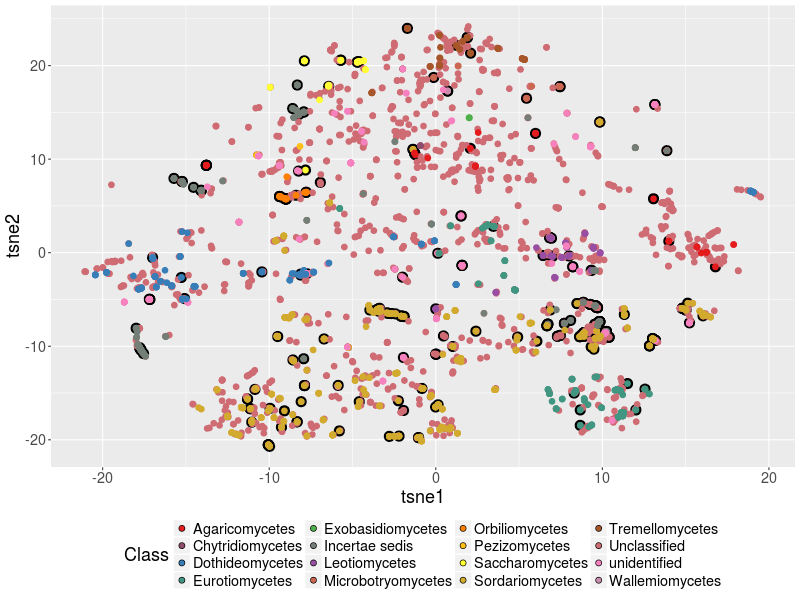

In [36]:
%%R -w 800 -h 600

#my_palette <- colorRampPalette(c("red", "yellow", "green"))(n = 299)

g$Rank2 = gsub("p__", "", g$Rank2)
g$Rank3 = gsub("c__", "", g$Rank3)
g$Rank4 = gsub("o__", "", g$Rank4)
g$group = gsub("c__", "", g$group)

asNumeric = function(x) { as.numeric(as.character(x)) }
p = ggplot(g, aes(x = asNumeric(tsne_1), y = asNumeric(tsne_2)))

p = p + geom_point(data = subset(g, padj <= 0.10), shape = 20, size = 7)


p = p + geom_point(aes(fill = group, color = group), pch = 21, size = 2.5) +
    guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6))) +
    #scale_fill_gradient(limits = c(0, 1), low="blue",high="green") + 
    #scale_colour_gradient(limits = c(0, 1), low="blue", high="green", name = "adjusted p-value") +
    guides(colour=FALSE)


colourCount = length(unique(d2$Rank3)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Set1"))
p = p + scale_color_manual(values = getPalette(colourCount))
p = p + scale_fill_manual(values = getPalette(colourCount), name = "Class")+ theme(text = element_text(size=18)) 

#p = p  + geom_point(data = subset(d2, Rank3 %in% c('unclassified', 'unidentified')), color = "black", size = 2)


p = p + xlab("tsne1") + ylab("tsne2") +  guides(color=FALSE) 
p = p + theme(legend.position= "bottom") + guides(fill=guide_legend(ncol=4))# + stat_ellipse(data = poss_Sords)



p     

In [37]:
%%R
ggsave("data/figs/tnseFig_resp.png", p, height = 8, width = 10)

In [38]:
%%R
g2 = g %>%
       mutate(status = ifelse(group == "Unclassified" | group == "unidentified" | group == "Incertae sedis", 'unk',
                              'known'))

In [39]:
%%R
length(unique(g$OTU))

[1] 1905


In [40]:
%%R
filter(g2, status == 'unk' & padj <=0.10) %>% select(OTU, Rank3, status) %>% summarize(n_incorp_OTUs = OTU %>% unique %>% length)


  n_incorp_OTUs
1            73


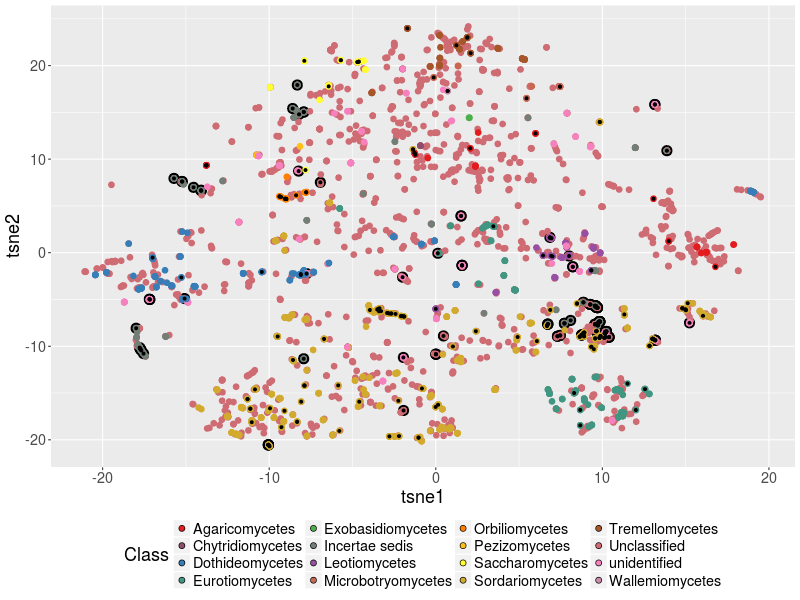

In [41]:
%%R -w 800 -h 600

#my_palette <- colorRampPalette(c("red", "yellow", "green"))(n = 299)

g$Rank2 = gsub("p__", "", g$Rank2)
g$Rank3 = gsub("c__", "", g$Rank3)
g$Rank4 = gsub("o__", "", g$Rank4)
g$group = gsub("c__", "", g$group)

asNumeric = function(x) { as.numeric(as.character(x)) }
p = ggplot(g2, aes(x = asNumeric(tsne_1), y = asNumeric(tsne_2)))


p = p + geom_point(data = filter(g2, status == 'unk' & padj <=0.10), shape = 20, size = 7, color = "black")


p = p + geom_point(aes(fill = group, color = group), pch = 21, size = 2.5) +
    guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6))) +
    #scale_fill_gradient(limits = c(0, 1), low="blue",high="green") + 
    #scale_colour_gradient(limits = c(0, 1), low="blue", high="green", name = "adjusted p-value") +
    guides(colour=FALSE)

p = p + geom_point(data = subset(g, padj <= 0.10), shape = 20, size = 2)


colourCount = length(unique(d2$Rank3)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Set1"))
p = p + scale_color_manual(values = getPalette(colourCount))
p = p + scale_fill_manual(values = getPalette(colourCount), name = "Class")+ theme(text = element_text(size=18)) 

#p = p  + geom_point(data = subset(d2, Rank3 %in% c('unclassified', 'unidentified')), color = "black", size = 2)


p = p + xlab("tsne1") + ylab("tsne2") +  guides(color=FALSE) 
p = p + theme(legend.position= "bottom") + guides(fill=guide_legend(ncol=4))# + stat_ellipse(data = poss_Sords)




p     

In [42]:
%%R
g2 = g %>% filter(padj <=0.10) %>% group_by(OTU) %>% mutate(numrespdays = as.factor(length(Day)))

In [43]:
%%R
g2 %>% group_by(numrespdays) %>% summarise(numOTU = length(unique(OTU)))

# A tibble: 4 x 2
  numrespdays numOTU
        <chr>  <int>
1           1    118
2           2     33
3           3     30
4           4     12


In [44]:
%%R
d.select = d %>% select(OTU, Abundance, Day) %>% 
            filter(grepl("^s", d$Sample)) %>% 
            group_by(OTU, Day) %>%
            summarise(meanAb = mean(Abundance))

In [140]:
%%R
g3 = full_join(g2, d.select, by = c("Day", "OTU")) %>% filter(!(is.na(numrespdays)))

In [141]:
%%R
g3 %>% group_by(numrespdays) %>% summarise(numOTU = length(unique(OTU)))

# A tibble: 4 x 2
  numrespdays numOTU
        <chr>  <int>
1           1    118
2           2     33
3           3     30
4           4     12


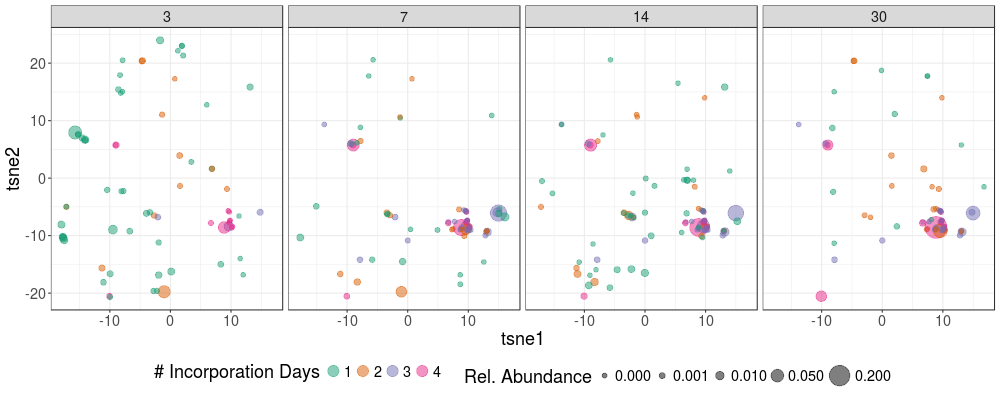

In [142]:
%%R -w 1000 -h 400

#my_palette <- colorRampPalette(c("red", "yellow", "green"))(n = 299)

g$Rank2 = gsub("p__", "", g$Rank2)
g$Rank3 = gsub("c__", "", g$Rank3)
g$Rank4 = gsub("o__", "", g$Rank4)
g$group = gsub("c__", "", g$group)

asNumeric = function(x) { as.numeric(as.character(x)) }
p = ggplot(g3, aes(x = asNumeric(tsne_1), y = asNumeric(tsne_2), color = numrespdays, size = meanAb))

p = p + geom_point(alpha = 0.5) + facet_wrap(~Day, nrow = 1)


#p = p + geom_point(aes(fill = group, color = group), pch = 21, size = 2.5) +
 #   guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6))) +
    #scale_fill_gradient(limits = c(0, 1), low="blue",high="green") + 
    #scale_colour_gradient(limits = c(0, 1), low="blue", high="green", name = "adjusted p-value") +
  #  guides(colour=FALSE)


colourCount = 4
getPalette = colorRampPalette(brewer.pal(4, "Dark2"))
p = p + scale_color_manual(name = "# Incorporation Days", values = getPalette(colourCount))
p = p + scale_fill_manual(values = getPalette(colourCount), name = "Class")

#p = p  + geom_point(data = subset(d2, Rank3 %in% c('unclassified', 'unidentified')), color = "black", size = 2)

p = p + theme_bw()

p = p + xlab("tsne1") + ylab("tsne2")
p = p + theme(legend.position= "bottom") + guides(colour = guide_legend(override.aes = list(size=5))) +
scale_size(name = "Rel. Abundance",range = c(2, 10), breaks = c(0, 0.001, 0.01, 0.05, 0.2)) + 
theme(text = element_text(size=18)) 



p     

In [48]:
%%R
ggsave("data/figs/tnseFig_revised.jpg", p, height = 6, width =12 )

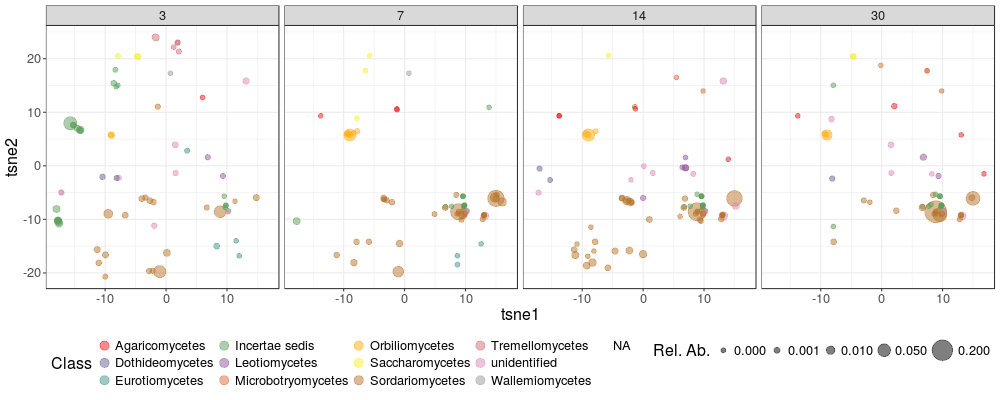

In [148]:
%%R -w 1000 -h 400

#my_palette <- colorRampPalette(c("red", "yellow", "green"))(n = 299)

g$Rank2 = gsub("p__", "", g$Rank2)
g$Rank3 = gsub("c__", "", g$Rank3)
g$Rank4 = gsub("o__", "", g$Rank4)
g$group = gsub("c__", "", g$group)

asNumeric = function(x) { as.numeric(as.character(x)) }
p2 = ggplot(g3, aes(x = asNumeric(tsne_1), y = asNumeric(tsne_2), color = Rank3, size = meanAb))

p2 = p2 + geom_point(alpha = 0.5) + facet_wrap(~Day, nrow = 1)


#p = p + geom_point(aes(fill = group, color = group), pch = 21, size = 2.5) +
 #   guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6))) +
    #scale_fill_gradient(limits = c(0, 1), low="blue",high="green") + 
    #scale_colour_gradient(limits = c(0, 1), low="blue", high="green", name = "adjusted p-value") +
  #  guides(colour=FALSE)


colourCount = 12
getPalette = colorRampPalette(brewer.pal(12, "Set1"))
p2 = p2 + scale_color_manual(name = "Class", values = getPalette(colourCount))
p2 = p2 + scale_fill_manual(values = getPalette(colourCount), name = "Class")

#p = p  + geom_point(data = subset(d2, Rank3 %in% c('unclassified', 'unidentified')), color = "black", size = 2)

p2 = p2 + theme_bw()

p2 = p2 + xlab("tsne1") + ylab("tsne2")
p2 = p2 + theme(legend.position= "bottom") + guides(colour = guide_legend(override.aes = list(size=4))) +
scale_size(name = "Rel. Ab.",range = c(2, 10), breaks = c(0, 0.001, 0.01, 0.05, 0.2)) + 
theme(text = element_text(size=16)) 



p2

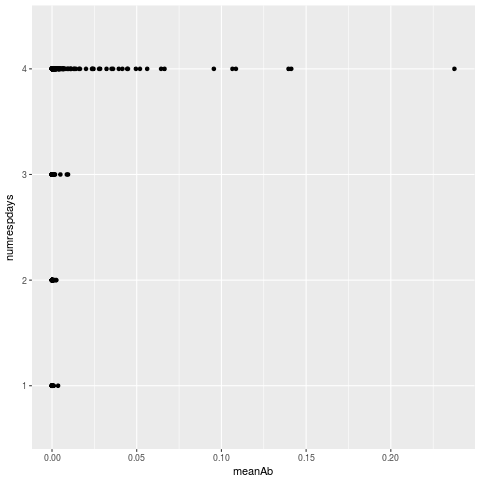

In [96]:
%%R 
p.RA = ggplot(g3, aes(x = meanAb, y = numrespdays)) + geom_point()

p.RA

In [132]:
%%R
library(cowplot)
plot(p,p2)


Error in if (newpage) grid.newpage() : 
  argument is not interpretable as logical


/home/chantal/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in if (newpage) grid.newpage() : 
  argument is not interpretable as logical

  warnings.warn(x, RRuntimeWarning)
/home/chantal/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: In if (newpage) grid.newpage() :
  warnings.warn(x, RRuntimeWarning)
/home/chantal/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:  the condition has length > 1 and only the first element will be used

  warnings.warn(x, RRuntimeWarning)


In [49]:
%%R
g3 = left_join(g, d.select, by = c("Day", "OTU"))
g3 = filter(g3, OTU %in% g2$OTU)
g3 = g3 %>% group_by(OTU) %>% mutate(numrespdays = as.factor(length(Day))) ##Need to add a 

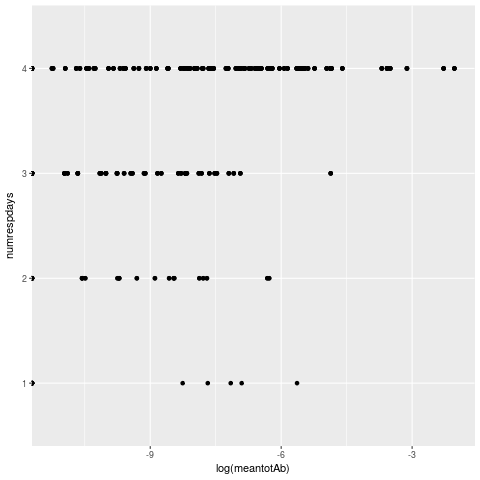

In [50]:
%%R
g4 = g3 %>% group_by(OTU) %>% mutate(meantotAb = mean(meanAb))
p2 = ggplot(g4, aes(y = numrespdays,x = log(meantotAb)))
p2 = p2 + geom_point()
p2

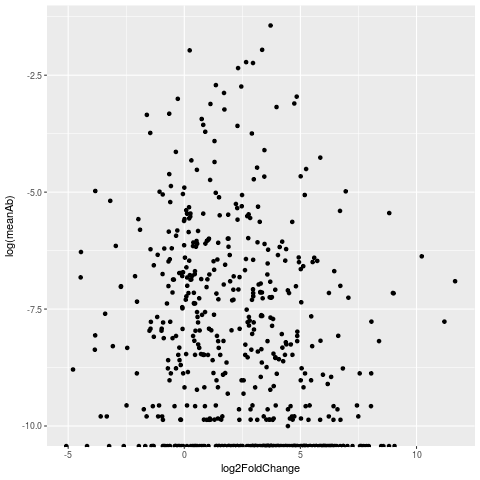

In [51]:
%%R
p2 = ggplot(g3, aes(y = log(meanAb),x = log2FoldChange))
p2 = p2 + geom_point()
p2

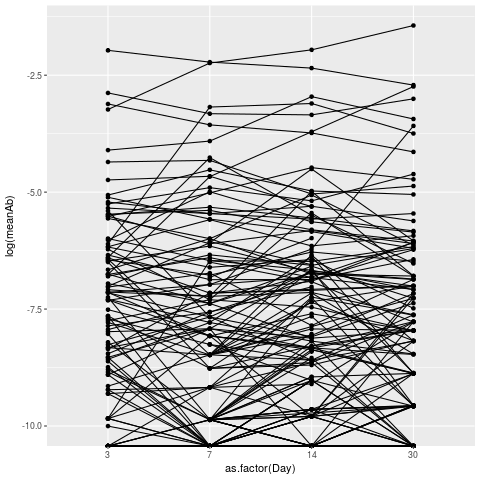

In [52]:
%%R
p2 = ggplot(g3, aes(y = log(meanAb),x = as.factor(Day)))
p2 = p2 + geom_point() + geom_line(aes(group = OTU))
p2

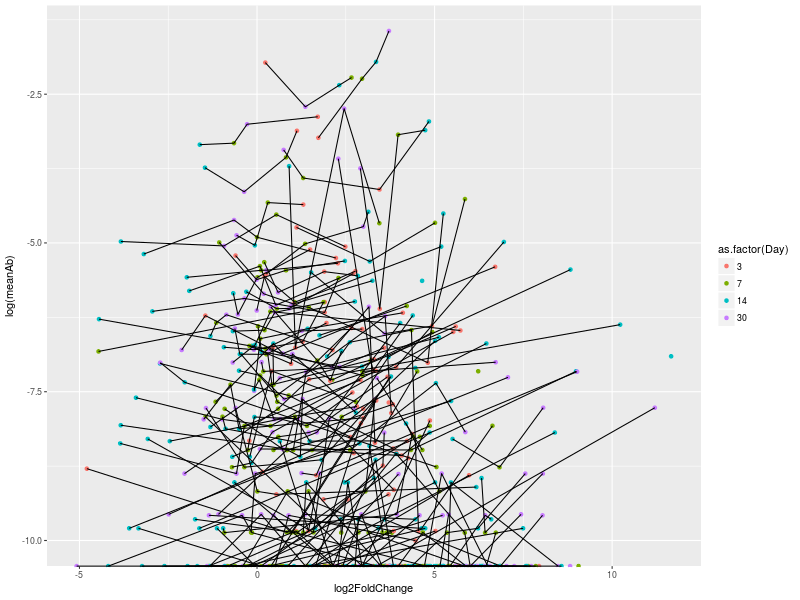

In [53]:
%%R -w 800 -h 600
##Making figure re: log RA vs LFC
p2 = ggplot(g3, aes(y = log(meanAb),x = log2FoldChange))
p2 = p2 + geom_point(aes(color = as.factor(Day))) + geom_line(aes(group = OTU))
p2

In [54]:
%%R
##Making figure re: log RA vs LFC : calculating ratio and then plotting by day
g4 = g3 %>% group_by(OTU, Day) %>% mutate(logRA_LFC = log(((meanAb)/log2FoldChange)))

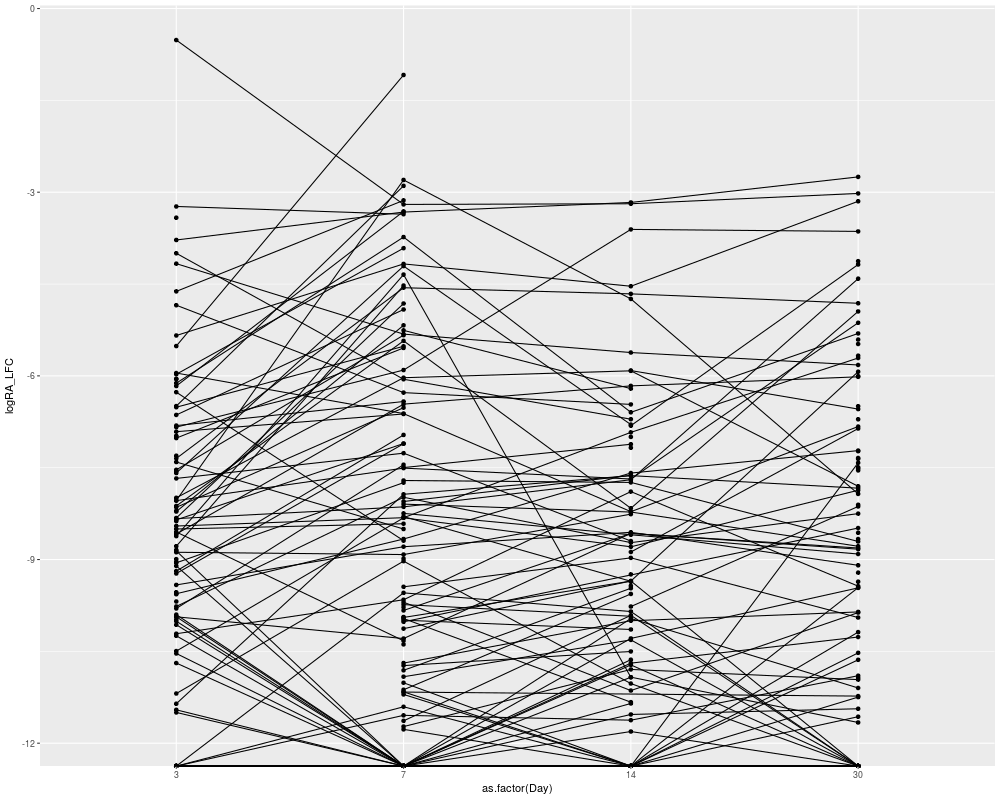

In [55]:
%%R -w 1000 -h 800
##Making figure re: log RA vs LFC
p2 = ggplot(g4, aes(x = as.factor(Day),y= logRA_LFC))
p2 = p2 + geom_point() + geom_line(aes(group = OTU))
p2

In [56]:
%%R
g$Rank6 = gsub("g__", "", g$Rank6) 
g$Rank7 = gsub("s__", "", g$Rank7) 

#unk = g %>% filter(Rank6 %in% c('unidentified', 'Incertae sedis')|is.na(Rank6)) %>%
     #       filter(Rank7 %in% c('unidentified', 'Incertae sedis')|is.na(Rank7)) %>%
      #      filter(padj <=0.10) #%>%
            #select(tsne_1, tsne_2, OTU) %>% unique() 

unk = g %>% 
    filter(is.na(Rank7) | grepl("unidentified", Rank7) | grepl("Incertae sedis", Rank7) | grepl("sp", Rank7)) %>%
    filter(Rank1 == "k__Fungi") %>%
    filter(padj <=0.10) %>%
    select(tsne_1, tsne_2, OTU) %>% unique() 


length(unique(unk$OTU))

[1] 157


In [57]:
%%R
df.known = g %>%  
  filter(!(is.na(Rank7)) & !(grepl("unidentified", Rank7)) & !(grepl("Incertae sedis", Rank7)) & 
         !(grepl("sp", Rank7))) %>%
  filter(padj<0.10) %>% 
  select(tsne_1, tsne_2, OTU, Rank3, Rank7) %>% unique() 

length(unique(df.known$OTU))

[1] 33


In [58]:
%%R
m = expand.grid(OTU_unk = unique(unk$OTU), OTU_known = unique(df.known$OTU))
head(m)

  OTU_unk OTU_known
1   OTU.7     OTU.3
2  OTU.50     OTU.3
3 OTU.108     OTU.3
4 OTU.297     OTU.3
5 OTU.534     OTU.3
6 OTU.595     OTU.3


In [59]:
%%R
test_dist = function(unk, known, OTU_unk, OTU_known){
    #filtering to one known and one unknown OTU
    known_filt = filter(known, OTU == OTU_known)
    unk_filt = filter(unk, OTU == OTU_unk)

    #creating df with coords
    coords = rbind(c(unk_filt$tsne_1, unk_filt$tsne_2), c(known_filt$tsne_1, known_filt$tsne_2))

    #calculating distance b/t known and unknown OTU coords
    d_tsne1 = dist(coords)
    
    #creating dataframe
    data.frame(OTU_unk, as.numeric(d_tsne1), OTU_known, known_filt$Rank3, known_filt$Rank7)

}

#test = mdply(unk, test_dist, class = df.class, classlist = df.class$Rank3 )

test = tbl_df(mdply(m,
                    test_dist, 
                    .parallel = TRUE, 
                    unk = unk, 
                    known = df.known))

head(test)

#ddply(.data, .variables, .fun = NULL, ..., .progress = "none", .inform = FALSE, .drop = TRUE, .parallel = FALSE, .paropts = NULL)


# A tibble: 6 x 5
  OTU_unk as.numeric.d_tsne1. OTU_known known_filt.Rank3
   <fctr>               <dbl>    <fctr>           <fctr>
1   OTU.7            5.833943     OTU.3  Sordariomycetes
2  OTU.50           28.918135     OTU.3  Sordariomycetes
3 OTU.108           20.069685     OTU.3  Sordariomycetes
4 OTU.297           15.722900     OTU.3  Sordariomycetes
5 OTU.534           30.096988     OTU.3  Sordariomycetes
6 OTU.595            5.375798     OTU.3  Sordariomycetes
# ... with 1 more variables: known_filt.Rank7 <fctr>


In [175]:
%%R
test2 = test %>% group_by(OTU_unk) %>% na.omit %>% 
          filter(as.numeric.d_tsne1. == min(as.numeric.d_tsne1.)) %>% 
          mutate(c = ifelse(as.numeric.d_tsne1. > 5.97, "Novel", as.character(known_filt.Rank3))) %>%
          mutate(s = ifelse(as.numeric.d_tsne1. > 5.97, "Novel", as.character(known_filt.Rank7))) %>%
          select(OTU_unk, as.numeric.d_tsne1., OTU_known, c, s)

test2

# A tibble: 157 x 5
# Groups:   OTU_unk [157]
     OTU_unk as.numeric.d_tsne1. OTU_known               c
      <fctr>               <dbl>    <fctr>           <chr>
 1   OTU.207          1.43875124     OTU.3 Sordariomycetes
 2  OTU.7449          0.07581795     OTU.3 Sordariomycetes
 3 OTU.10238          1.24591119     OTU.3 Sordariomycetes
 4    OTU.14          0.36535650    OTU.29  Incertae sedis
 5    OTU.22          0.55638748    OTU.29  Incertae sedis
 6    OTU.27          0.49185037    OTU.29  Incertae sedis
 7   OTU.198          5.80240456    OTU.29  Incertae sedis
 8   OTU.250          0.56357470    OTU.29  Incertae sedis
 9   OTU.448          0.68297741    OTU.29  Incertae sedis
10 OTU.17165          2.75226391    OTU.29  Incertae sedis
# ... with 147 more rows, and 1 more variables: s <chr>


In [176]:
%%R
assign_table = test2 %>% 
                    rename(OTU = OTU_unk, "Euc. Dist." = as.numeric.d_tsne1., `Classified OTU` = OTU_known,  
                    Class = c, Species = s) 
head(assign_table)

# A tibble: 6 x 5
# Groups:   OTU [6]
        OTU `Euc. Dist.` `Classified OTU`           Class
     <fctr>        <dbl>           <fctr>           <chr>
1   OTU.207   1.43875124            OTU.3 Sordariomycetes
2  OTU.7449   0.07581795            OTU.3 Sordariomycetes
3 OTU.10238   1.24591119            OTU.3 Sordariomycetes
4    OTU.14   0.36535650           OTU.29  Incertae sedis
5    OTU.22   0.55638748           OTU.29  Incertae sedis
6    OTU.27   0.49185037           OTU.29  Incertae sedis
# ... with 1 more variables: Species <chr>


In [177]:
%%R
library(xtable)
full = xtable(assign_table)
print(full, type = "latex",
      file="data/figs/tsne_assignments.tex",
      include.rownames = FALSE, 
      tabular.environment="longtable")

In [178]:
%%R
assign_table %>% group_by(Class) %>% count

# A tibble: 10 x 2
# Groups:   Class [10]
                Class     n
                <chr> <int>
 1     Agaricomycetes     1
 2    Dothideomycetes     5
 3     Incertae sedis     9
 4      Leotiomycetes    22
 5 Microbotryomycetes     5
 6              Novel    27
 7     Orbiliomycetes    11
 8    Saccharomycetes     3
 9    Sordariomycetes    71
10    Tremellomycetes     3


In [171]:
%%R
assign_table %>% group_by(Species, Class) %>% count %>% arrange(-n)

# A tibble: 30 x 3
# Groups:   Species, Class [30]
                     Species           Class     n
                      <fctr>           <chr> <int>
 1       Chaetomium funicola Sordariomycetes    43
 2  Phialocephala xalapensis   Leotiomycetes    22
 3     Arthrobotrys conoides  Orbiliomycetes    11
 4       Humicola nigrescens Sordariomycetes    10
 5        Mortierella exigua  Incertae sedis     8
 6 Purpureocillium lilacinum           Novel     8
 7 Purpureocillium lilacinum Sordariomycetes     6
 8         Dendryphion nanum Dothideomycetes     5
 9       Chaetomium funicola           Novel     5
10       Humicola nigrescens           Novel     4
# ... with 20 more rows


In [166]:
%%R
head(test2)

# A tibble: 6 x 5
    OTU_unk as.numeric.d_tsne1. OTU_known               c
     <fctr>               <dbl>    <fctr>           <chr>
1   OTU.207          1.43875124     OTU.3 Sordariomycetes
2  OTU.7449          0.07581795     OTU.3 Sordariomycetes
3 OTU.10238          1.24591119     OTU.3 Sordariomycetes
4    OTU.14          0.36535650    OTU.29  Incertae sedis
5    OTU.22          0.55638748    OTU.29  Incertae sedis
6    OTU.27          0.49185037    OTU.29  Incertae sedis
# ... with 1 more variables: known_filt.Rank7 <fctr>


In [91]:
%%R
#FIGURE THIS OUT!!!!
filter(test2, OTU_known == "OTU.3")#as.numeric.d_tsne1. > 6)


Error in filter_impl(.data, quo) : Column `OTU` is unknown


In [86]:
%%R
test3 = test2 %>% group_by(known_filt.Rank3) %>% summarise(cat = OTU_unk %>% unique %>% length, 
                                                           mean_dist = mean(as.numeric.d_tsne1.),
                                                          max_dist = max(as.numeric.d_tsne1.)) 

test3

# A tibble: 9 x 4
    known_filt.Rank3   cat mean_dist  max_dist
              <fctr> <int>     <dbl>     <dbl>
1    Sordariomycetes    90  3.631382 10.194982
2     Incertae sedis     9  1.896153  5.830580
3    Saccharomycetes     3  1.399521  2.183304
4    Tremellomycetes     3  3.638465  3.730774
5    Dothideomycetes     6  4.074695  6.734135
6      Leotiomycetes    23  3.922591  9.476560
7     Agaricomycetes     4  6.753124  7.490495
8 Microbotryomycetes     5  3.422097  5.201700
9     Orbiliomycetes    14  3.823666  6.732461


In [92]:
%%R
head(test2)

# A tibble: 6 x 5
    OTU_unk as.numeric.d_tsne1. OTU_known known_filt.Rank3
     <fctr>               <dbl>    <fctr>           <fctr>
1   OTU.207          1.43875124     OTU.3  Sordariomycetes
2  OTU.7449          0.07581795     OTU.3  Sordariomycetes
3 OTU.10238          1.24591119     OTU.3  Sordariomycetes
4    OTU.14          0.36535650    OTU.29   Incertae sedis
5    OTU.22          0.55638748    OTU.29   Incertae sedis
6    OTU.27          0.49185037    OTU.29   Incertae sedis
# ... with 1 more variables: known_filt.Rank7 <fctr>


In [66]:
%%R
ggsave("data/figs/tnseFig.jpg", p, height = 8, width =10 )

In [65]:
%%R
filter(test, OTU_unk == 'OTU.108')

# A tibble: 33 x 5
   OTU_unk as.numeric.d_tsne1. OTU_known known_filt.Rank3
    <fctr>               <dbl>    <fctr>           <fctr>
 1 OTU.108           20.069685     OTU.3  Sordariomycetes
 2 OTU.108           16.749084    OTU.29   Incertae sedis
 3 OTU.108           37.377208    OTU.31  Saccharomycetes
 4 OTU.108            9.201815    OTU.53  Sordariomycetes
 5 OTU.108           32.954371    OTU.59   Incertae sedis
 6 OTU.108            7.544404    OTU.62  Sordariomycetes
 7 OTU.108            9.444418   OTU.127  Sordariomycetes
 8 OTU.108           40.843288   OTU.129  Tremellomycetes
 9 OTU.108           17.076595   OTU.155  Dothideomycetes
10 OTU.108           35.364534   OTU.181   Incertae sedis
# ... with 23 more rows, and 1 more variables: known_filt.Rank7 <fctr>


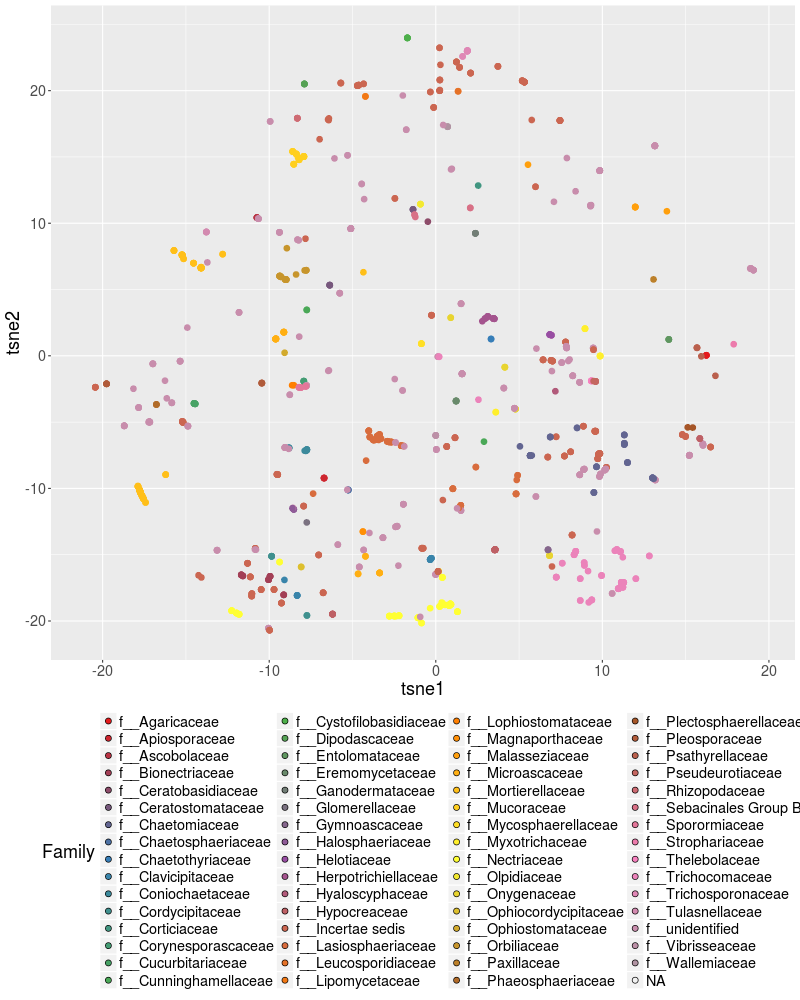

In [67]:
%%R -w 800 -h 1000

#my_palette <- colorRampPalette(c("red", "yellow", "green"))(n = 299)


asNumeric = function(x) { as.numeric(as.character(x)) }
p = ggplot(g, aes(x = asNumeric(tsne_1), y = asNumeric(tsne_2)))
#p = p + geom_point(data = subset(d2, padj <= 0.10), shape = 20, size = 7)
p = p + geom_point(aes(fill = Rank5, color = Rank5), pch = 21, size = 2.5) +
    guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6))) +
    #scale_fill_gradient(limits = c(0, 1), low="blue",high="green") + 
    #scale_colour_gradient(limits = c(0, 1), low="blue", high="green", name = "adjusted p-value") +
    guides(colour=FALSE)

colourCount = length(unique(d2$Rank5)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Set1"))
p = p + scale_color_manual(values = getPalette(colourCount))
p = p + scale_fill_manual(values = getPalette(colourCount), name = "Family")+ theme(text = element_text(size=18)) 

#p = p  + geom_point(data = subset(d2, Rank3 %in% c('unclassified', 'unidentified')), color = "black", size = 2)


p = p + xlab("tsne1") + ylab("tsne2") +  guides(color=FALSE) 
p = p + theme(legend.position= "bottom") + guides(fill=guide_legend(ncol=4))



p     

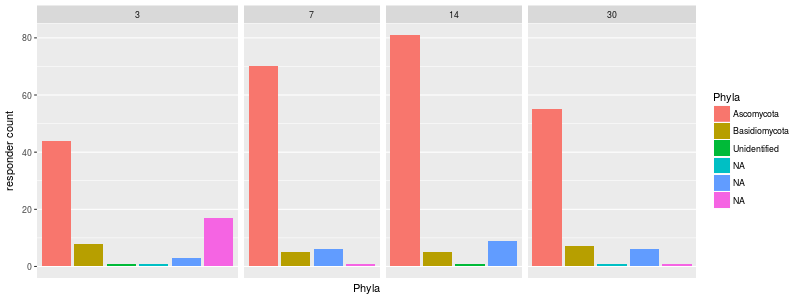

In [68]:
%%R -w 800 -h 300

dcounts = d2 %>%
          group_by(Day,Rank2) %>%
          summarize(responders = sum(padj<= 0.10)) 

dcounts = filter(dcounts, responders !=0)          
dcounts$Rank2[is.na(dcounts$Rank2)] = "p__unidentified"

p2 = ggplot(dcounts, aes(x = Rank2 , y = responders, fill = Rank2)) +
    facet_grid(. ~ Day, scales = "free_x", space = "free") +
    geom_bar(stat = "identity") +
    xlab("Phyla") + ylab("responder count") +
    scale_x_discrete(breaks=NULL) +
    scale_fill_discrete(name = "Phyla", labels = c("Ascomycota", "Basidiomycota", "Unidentified"))
                        

p2

In [69]:
%%R
ggsave("data/figs/responderCounts.jpg", p2, height = 3, width = 8)

In [70]:
%%R
tail(filter(d2, Rank2 == "p__unidentified"))

     tsne_1     tsne_2       OTU Day log2FoldChange            p         padj
55  7.83281  0.7068321 OTU.20687  14      0.3670555 4.551084e-01 1.000000e+00
56  7.83281  0.7068321 OTU.20687  30     -0.2668396 7.198220e-01 1.000000e+00
57  7.83281  0.7068321 OTU.20687   3      1.8100882 5.483380e-02 2.323466e-01
58 10.20324 -8.5436990 OTU.26170   7      3.5545561 8.752521e-04 1.123240e-02
59 10.20324 -8.5436990 OTU.26170  14      6.8376467 4.205485e-11 1.277752e-09
60 10.20324 -8.5436990 OTU.26170  30      3.4223859 2.818096e-03 2.171723e-02
      Rank1           Rank2           Rank3           Rank4           Rank5
55 k__Fungi p__unidentified c__unidentified o__unidentified f__unidentified
56 k__Fungi p__unidentified c__unidentified o__unidentified f__unidentified
57 k__Fungi p__unidentified c__unidentified o__unidentified f__unidentified
58 k__Fungi p__unidentified c__unidentified o__unidentified f__unidentified
59 k__Fungi p__unidentified c__unidentified o__unidentified f__unidentifie

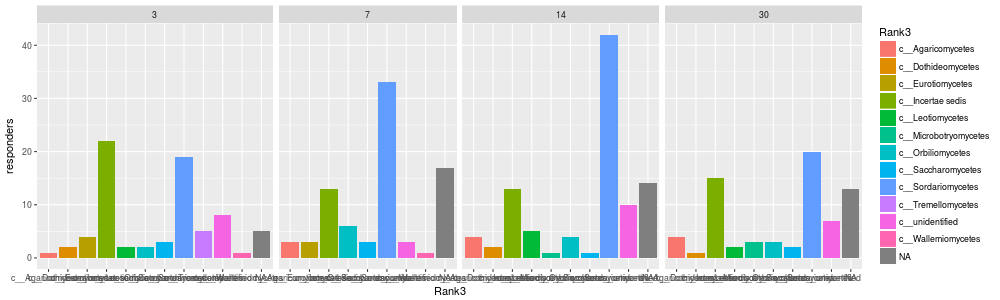

In [71]:
%%R -w 1000 -h 300

dcounts = d2 %>%
          group_by(Day,Rank3) %>%
          summarize(responders = sum(padj<= 0.10)) 

dcounts = filter(dcounts, responders !=0)          


p = ggplot(dcounts, aes(x = Rank3 , y = responders, fill = Rank3)) +
    facet_grid(. ~ Day, scales = "free_x", space = "free") +
    geom_bar(stat = "identity")

p

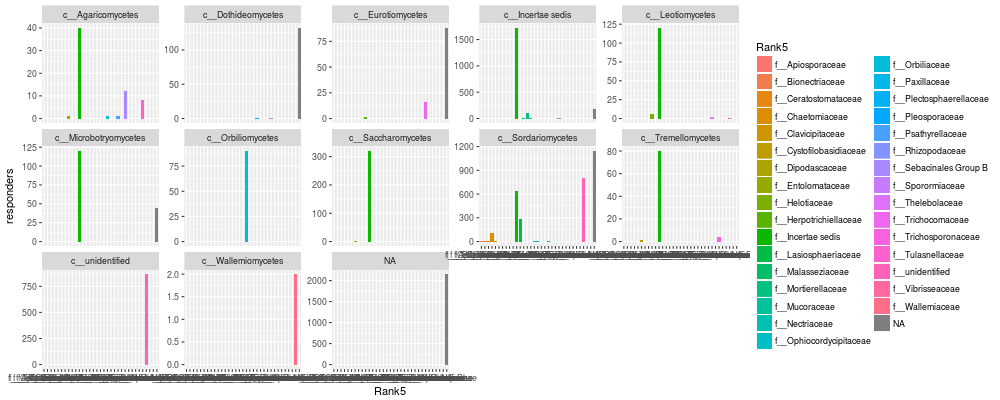

In [72]:
%%R -w 1000 -h 400

dcounts = d2 %>%
          filter(padj <= 0.10) %>%
          group_by(Rank5) %>%
          mutate(responders = sum(length(unique(OTU))))%>%
          ungroup()  

dcounts = filter(dcounts, responders > 0)          


p = ggplot(dcounts, aes(x = Rank5 , y = responders, fill = Rank5)) +
    facet_wrap(~ Rank3, scales = "free_y", ncol =5) +
    geom_bar(stat = "identity") 
p

In [73]:
%%R
head(d2) %>% as.data.frame

    tsne_1   tsne_2   OTU Day log2FoldChange            p         padj    Rank1
1 9.799208 -7.39636 OTU.1   7       3.043996 2.361174e-11 1.363578e-09 k__Fungi
2 9.799208 -7.39636 OTU.1  14       4.398721 6.749928e-18 3.855559e-16 k__Fungi
3 9.799208 -7.39636 OTU.1  30       2.424323 2.108905e-03 1.692353e-02 k__Fungi
4 9.799208 -7.39636 OTU.1   3       3.075985 3.179682e-08 1.987302e-06 k__Fungi
5 8.875103 -8.57920 OTU.2   7       2.958096 6.752304e-10 3.342390e-08 k__Fungi
6 8.875103 -8.57920 OTU.2  14       3.351991 6.641207e-08 1.129005e-06 k__Fungi
          Rank2              Rank3             Rank4             Rank5
1 p__Ascomycota  c__Incertae sedis o__Incertae sedis f__Incertae sedis
2 p__Ascomycota  c__Incertae sedis o__Incertae sedis f__Incertae sedis
3 p__Ascomycota  c__Incertae sedis o__Incertae sedis f__Incertae sedis
4 p__Ascomycota  c__Incertae sedis o__Incertae sedis f__Incertae sedis
5 p__Ascomycota c__Sordariomycetes    o__Sordariales   f__unidentified
6 p__Ascomycot

In [74]:
%%R -w 1000 -h 400

dcounts = d2 %>%
          group_by(Rank5) %>%
          filter(padj<=0.10, Rank3 == "Sordariomycetes") %>%
          mutate(responders = sum(length(unique(OTU))))%>%
          ungroup()  

dcounts = filter(dcounts, responders > 0)          


p = ggplot(dcounts, aes(x = Rank5 , y = responders, fill = Rank5)) +
    facet_wrap(~ Rank3, scales = "free_y", ncol =5) +
    geom_bar(stat = "identity") 
p

/home/chantal/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error: Faceting variables must have at least one value

  warnings.warn(x, RRuntimeWarning)
/home/chantal/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/home/chantal/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 1: 
  warnings.warn(x, RRuntimeWarning)
/home/chantal/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: In brewer.pal(10, "Set1") :
  warnings.warn(x, RRuntimeWarning)
/home/chantal/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
 
  warnings.warn(x, RRuntimeWarning)
/home/chantal/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:  n too large, allowed maximum for palette Set1 is 9
Returning the palette you asked for with that 

RRuntimeError: Error: Faceting variables must have at least one value


In [ ]:
%%R
d3 = filter(d2, padj <=0.10)
d3$tsne_1 = asNumeric(d3$tsne_1)
d3$tsne_2 = asNumeric(d3$tsne_2)
d3 = filter(d3, tsne_1 > 19)
d3 = filter(d3, tsne_2 > 7)
d3 = filter(d3, tsne_2 <13)

In [ ]:
%%R
length(d3$OTU)

In [ ]:
%%R -w 600 -h 600

my_palette <- colorRampPalette(c("red", "yellow", "green"))(n =299)


asNumeric = function(x) { as.numeric(as.character(x)) }
p = ggplot(d3, aes(x = asNumeric(tsne_1), y = asNumeric(tsne_2)))+
    geom_point(aes(fill = padj, color = padj, alpha = 0.85), pch = 21) +
    guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6))) +
    scale_fill_gradient(low="red",high="yellow") + scale_colour_gradient(low="red",high="yellow") +
    guides(fill=FALSE)


p     

In [ ]:
%%R
OTUs = d3$OTU 

In [ ]:
%%R
counts = filter(d, OTU %in% OTUs)

In [ ]:
%%R
head(dcounts)

In [ ]:
%%R

dcounts = d3 %>%
          group_by(Day,Rank6) %>%
          summarize(responders = sum(padj<= 0.10))

p = ggplot(dcounts, aes(x = Rank6 , y = responders, fill = Rank6)) +
    facet_grid(. ~ Day, scales = "free_x", space = "free") +
    geom_bar(stat = "identity")


#px = ggplot(d, aes(x = factor(Day), y = responders, fill = RNA_DNA))

#px = px + facet_grid(. ~ Day, scales = "free_x", space = "free")

#px = px + geom_bar(stat = "identity", position = "dodge")

    #geom_point(aes(fill = padj, color = padj, alpha = 0.85), pch = 21) +
    #uides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6))) +
    #scale_fill_gradient(low="red",high="yellow") + scale_colour_gradient(low="red",high="yellow") +
    #guides(fill=FALSE)
p

In [ ]:
%%R
head(d3)

###Blasting vs. Living Tree Project for Responders

In [ ]:
%%R
q = arrange(resp, padj)
OTU = unique(q$OTU)
length(OTU)

In [ ]:
%%R
head(OTU, n = 10)

In [ ]:
from Bio.Blast.Applications import NcbiblastnCommandline as blast

In [ ]:
from cogent import LoadSeqs, DNA

In [ ]:
%%bash
formatdb -i /home/chantal/FungalSIP/data/tmp/db/its_12_11_otus/rep_set/97_otus.fasta -p F

In [ ]:
OTU_ids = ["OTU.98", "OTU.49", "OTU.53", "OTU.90", "OTU.279", "OTU.6893", "OTU.460", "OTU.6893"]
seqs = LoadSeqs("/home/chantal/FungalSIP/data/otusn.fasta", moltype=DNA, aligned=False)
seqs = seqs.takeSeqs(OTU_ids).toFasta()
print seqs

In [ ]:
my_file = open("seqs.fasta", "w")
my_file.write(seqs)
my_file.close()

In [ ]:
cline = blast(query = "seqs.fasta",
              db = "/home/chantal/FungalSIP/data/tmp/db/its_12_11_otus/rep_set/97_otus.fasta",
              outfmt = 6,
              out = "otusn_silvaRefNR115.m6",
              num_threads = 5)
print cline
cline()

In [ ]:
!head -n1 otusn_silvaRefNR115.m6
!wc -l otusn_silvaRefNR115.m6
! grep -c "OTU.279" otusn_silvaRefNR115.m6

In [ ]:
from IPython.display import Image
import pandas.rpy.common as com

In [ ]:
%%R
library(data.table)
library(dplyr)

In [ ]:
%%R
blastout_dt = fread("otusn_silvaRefNR115.m6")
blastout_df = tbl_df(blastout_dt)
colnames(blastout_df) = c("OTU",
                        "acc",
                        "pid",
                        "aln.length",
                        "mismatches",
                        "gapOpenCount",
                        "qstart",
                        "qend",
                        "sstart",
                        "send",
                        "e.value",
                        "bit.score")

top_hits_df_LTP = blastout_df %>% 
                          group_by(OTU) %>% 
                          mutate(Rank = rank(desc(bit.score), ties.method = "min")) #%>% 
                          #filter(pid > 97.0) %>%
                          #filter(e.value < 5.0e-180) %>%
                          #filter(acc %in% c('AM286414', 'AB428568', 'EU877263', 'EF575565', 'EF494193', 'X82449'))

In [ ]:
%%R
print(head(top_hits_df_LTP))
str(top_hits_df_LTP$OTU)

In [ ]:
! head data/tmp/db/its_12_11_otus/taxonomy/otu_taxonomy.txt

In [ ]:
%%R
dt = fread("data/tmp/db/its_12_11_otus/taxonomy/97_otu_taxonomy.txt", sep = ";", header = FALSE)
dat1 <- data.frame(do.call(rbind, strsplit(as.vector(dt$V1), split = "\t")))
dt <- cbind(dat1, dt)
dt$V1 = NULL
colnames(dt) = c("acc","Kingdom","Phylum","Class","Order","Family","Genus", "Species")
ITS_seq_data = tbl_df(dt)
head(dt)

In [ ]:
%%R
joined_df = left_join(top_hits_df_LTP, ITS_seq_data)

In [ ]:
%%R
head(joined_df)

In [ ]:
%%R
joined_df = filter(joined_df, name != "NA")

In [ ]:
%%R
dim(joined_df)

In [ ]:
%%R
head(joined_df)

In [ ]:
df = com.load_data("joined_df")

In [ ]:
def get_latex(df):
    latex = ""
    prefix = r"\multirow{%s}{*}{%s}"%(len(df.index), df.OTU.iloc[0])
    for i, r in df[["Genus", "Species","pid","acc"]].iterrows():
        latex += " & " + " & ".join([str(i) for i in r.values]) + r" \\ "
    return prefix + latex + r"\midrule" + "\n"

In [ ]:
s = df.groupby("OTU").apply(get_latex)

table_framework = r"""
\documentclass[11pt]{article}
\usepackage{multirow, array, booktabs}
\begin{document}

\thispagestyle{empty}
 
\begin{table}[ht]
\caption{$^{13}$C RNA responders BLAST against Living Tree Project}
\begin{center}
\begin{tabular}{l>{\itshape}lrl}
    \toprule \\
    \textbf{OTU ID} & \textbf{Species Name} & \textbf{BLAST percent identity} & \textbf{accession} \\
    \midrule
    %s
    \bottomrule
\end{tabular}
\end{center}
\label{tab:multicol}
\end{table}
 
\end{document}"""%"".join(s.values)

with open("data/table.tex", "w") as out:
    out.write(table_framework)

In [ ]:
!latex -output-directory="data/tmp" data/tmp/table.tex >/dev/null 2>&1 && \
dvipng -o data/table.png data/tmp/table.dvi >/dev/null 2>&1
Image("data/table.png")